In [1]:
using GrootSim

using CSV
using DataFrames
using Dates
using Distributions
using DotEnv
DotEnv.load!()
using PyPlot
using Serialization

using PyCall
pickle = pyimport("pickle");

[ Info: Precompiling GrootSim [84197a3c-ab72-42ed-a031-1046bb28d0ec] (cache misses: include_dependency fsize change (2))


## Evaluation data params

In [2]:
basepath = ENV["EVALUATION_RESULTS_PATH"]
outpath = ENV["PAPER_RESULTS_PATH"];

In [3]:
time_window = "day"
net_models = ["hypergraph", "clique", "graph"]
# involvements = ["high_involvement", "medium_involvement", "low_involvement"]
involvements = ["medium_involvement"]
# thrs = [2, 3, 4]
thrs = [4];

In [4]:
eval_res_path = joinpath(basepath, "$(time_window)");

In [5]:
subreddits_to_eval = [
    "AskReddit",
    "bayarea",
    "California",
    "collapse",
    "news",
    "politics",
    "AskReddit_collapse",
    "AskReddit_news",
    "AskReddit_politics",
    "bayarea_news",
    "collapse_news",
    "collapse_politics",
    "AskReddit_news_politics",
    "collapse_news_politics",
    "all"
];

## Utils

In [6]:
subreddit_labels = [
    "r/AskReddit",
    "r/bayarea",
    "r/California",
    "r/collapse",
    "r/news",
    "r/politics",
    "r/AskReddit;r/collapse",
    "r/AskReddit;r/news",
    "r/AskReddit;r/politics",
    "r/bayarea;r/news",
    "r/collapse;r/news",
    "r/collapse;r/politics",
    "r/AskReddit;r/news;r/politics",
    "r/collapse;r/news;r/politics",
    "All subreddits"
];

## Eval he sorting by average he size

In [7]:
he_stats_path = joinpath(ENV["PRECOMPUTED_PARAMS_PATH"], time_window, "hyperedges_stats.csv")
he_stats_df = CSV.File(he_stats_path) |> DataFrame;

In [8]:
first(he_stats_df, 5)

Row,subreddit,type,number_hes,avg_he_number_per_interval,avg_he_size_per_interval,avg_he_size_per_interval_no_empty_intervals,avg_hes_size,median_hes_size,std_hes_size,quantile_hes_size
,String31,String15,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,AskReddit,temporal,857,0.988466,3.76754,5.0099,5.19953,4.0,4.10306,9.0
2,AskReddit,snap,2391,2.61884,3.83041,5.0031,5.19532,4.0,5.81902,8.0
3,bayarea,temporal,558,1.76025,2.67834,4.4452,4.66487,3.0,3.94357,7.0
4,bayarea,snap,329,0.36035,0.551842,4.26976,4.58967,3.0,3.36209,7.0
5,California,temporal,578,1.67052,2.57091,4.21581,4.19377,3.0,2.01738,7.0


In [9]:
# 1. filter he_stats_csv by filtering out the snap type 
he_stats_df = he_stats_df[he_stats_df.type .!= "snap", :]

# 2. sort by avg he size per simulation interval 
he_stats_df = sort(he_stats_df, :avg_he_size_per_interval);

In [10]:
he_stats_df

Row,subreddit,type,number_hes,avg_he_number_per_interval,avg_he_size_per_interval,avg_he_size_per_interval_no_empty_intervals,avg_hes_size,median_hes_size,std_hes_size,quantile_hes_size
,String31,String15,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,California,temporal,578,1.67052,2.57091,4.21581,4.19377,3.0,2.01738,7.0
2,bayarea,temporal,558,1.76025,2.67834,4.4452,4.66487,3.0,3.94357,7.0
3,bayarea_news,temporal,2945,5.11285,3.14446,4.55078,5.06961,3.0,9.11764,7.0
4,news,temporal,2405,4.68811,3.25304,4.68767,5.14802,3.0,9.78885,7.0
5,AskReddit,temporal,857,0.988466,3.76754,5.0099,5.19953,4.0,4.10306,9.0
6,AskReddit_news,temporal,1346,1.54713,3.85058,4.97772,5.13447,4.0,4.78059,8.0
7,AskReddit_politics,temporal,1313,1.51442,3.88328,4.98785,5.25819,4.0,5.20535,9.0
8,AskReddit_news_politics,temporal,1802,2.07126,3.95306,4.96272,5.19367,4.0,5.36753,8.0
9,politics,temporal,1763,2.94816,4.07745,5.26634,5.61883,3.0,10.7551,9.0


## Across nets

### Criterion C3: capacity of the model to predict users' final opinions.

In [11]:
sorted_subreddits = he_stats_df.subreddit;

In [12]:
labels = ["$(row.subreddit) ($(round(row.avg_he_size_per_interval; digits = 2)))" for row in eachrow(he_stats_df)];

#### In the following, we consider all users (regardless whether they changes or not opinion from the beginning)

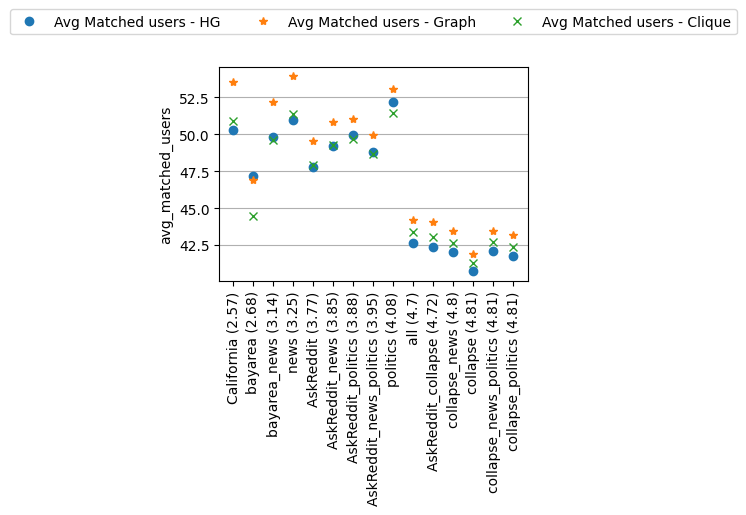

In [13]:
fig, axs = plt.subplots(1, 1, figsize=(6, 6))

# axs[1].set_xticks([])
# axs[2].set_xticks([])
axs.set_xticks(range(0, length(subreddits_to_eval)-1), labels, fontsize="10", rotation=90)

#
# HG
#
avg_matched_users = []
median_matched_users = []
std_matched_users = []

avg_drifted_users = []
median_drifted_users = []
std_drifted_users = []

#
# CLIQUE
#
avg_matched_users_cl = []
median_matched_users_cl = []
std_matched_users_cl = []

avg_drifted_users_cl = []
median_drifted_users_cl = []
std_drifted_users_cl = []

#
# GRAPH
#
avg_matched_users_gr = []
median_matched_users_gr = []
std_matched_users_gr = []

avg_drifted_users_gr = []
median_drifted_users_gr = []
std_drifted_users_gr = []

thr = 4
eval_func = "last_stance"
involvement = "medium_involvement"

for (thr_idx, thr) in enumerate(thrs)
    #loading evaluation data
    data = _loading_data(thr, subreddits_to_eval, eval_func, eval_res_path)
    # println((data))

    for idx in 1:length(subreddits_to_eval)
        subreddit_name = sorted_subreddits[idx]
        subreddit_data = data[subreddit_name] 

        # println(subreddit_name)

        #[perc_matched_users, perc_drifted_users]

        # HYPERGRAPH
        perc_matched_users, perc_drifted_users = get_last_stance_data(subreddit_data, involvement, "hypergraph")

        _avg_matched_users = mean(perc_matched_users)
        _median_matched_users = median(perc_matched_users)
        _std_matched_users = std(perc_matched_users)

        push!(avg_matched_users, _avg_matched_users)
        push!(median_matched_users, _median_matched_users)
        push!(std_matched_users, _std_matched_users)

        _avg_perc_drifted_users = mean(perc_drifted_users)
        _median_perc_drifted_users = median(perc_drifted_users)
        _std_perc_drifted_users = std(perc_drifted_users)

        push!(avg_drifted_users, _avg_perc_drifted_users)
        push!(median_drifted_users, _median_perc_drifted_users)
        push!(std_drifted_users, _std_perc_drifted_users)

        # CL
        perc_matched_users_cl, perc_drifted_users_cl = get_last_stance_data(subreddit_data, involvement, "clique")

        _avg_matched_users_cl = mean(perc_matched_users_cl)
        _median_matched_users_cl = median(perc_matched_users_cl)
        _std_matched_users_cl = std(perc_matched_users_cl)

        push!(avg_matched_users_cl, _avg_matched_users_cl)
        push!(median_matched_users_cl, _median_matched_users_cl)
        push!(std_matched_users_cl, _std_matched_users_cl)

        _avg_drifted_users_cl = mean(perc_drifted_users_cl)
        _median_drifted_users_cl = median(perc_drifted_users_cl)
        _std_drifted_users_cl = std(perc_drifted_users_cl)

        push!(avg_drifted_users_cl, _avg_drifted_users_cl)
        push!(median_drifted_users_cl, _median_drifted_users_cl)
        push!(std_drifted_users_cl, _std_drifted_users_cl)
 
        # GR 
        perc_matched_users_gr, perc_drifted_users_gr = get_last_stance_data(subreddit_data, involvement, "graph")
        
        _avg_matched_users_gr = mean(perc_matched_users_gr)
        _median_matched_users_gr = median(perc_matched_users_gr)
        _std_matched_users_gr = std(perc_matched_users_gr)

        push!(avg_matched_users_gr, _avg_matched_users_gr)
        push!(median_matched_users_gr, _median_matched_users_gr)
        push!(std_matched_users_gr, _std_matched_users_gr)

        _avg_drifted_users_gr = mean(perc_drifted_users_gr)
        _median_drifted_users_gr = median(perc_drifted_users_gr)
        _std_drifted_users_gr = std(perc_drifted_users_gr)

        push!(avg_drifted_users_gr, _avg_drifted_users_gr)
        push!(median_drifted_users_gr, _median_drifted_users_gr)
        push!(std_drifted_users_gr, _std_drifted_users_gr)

    end # end over subreddits

    # println(avg_drifted_users)
    # println(avg_drifted_users_cl)
    # println(avg_drifted_users_gr)

    # println(avg_matched_users)
    # println(avg_matched_users_cl)
    # println(avg_matched_users_gr)


    # ylim 
    #axs.set_ylim([0, 0.5])

    # ygrid
    axs.grid(axis="y")

    # println(f1_medians_cl)
    # println(f1_variances_cl)
    
    axs.plot(avg_matched_users, label="Avg Matched users - HG", marker="o", linestyle="None")
    # axs.plot(avg_drifted_users, label="Avg Drifted users - HG", marker="o", linestyle="None")
    # axs.errorbar(
    #     collect(range(0, length(subreddits_to_eval)-1)), 
    #     f1_medians, 
    #     yerr=f1_variances, 
    #     label="Median F1 - HG", 
    #     marker="o", 
    #     linestyle="None"
    # )

    # axs[thr_idx].plot(f1_means, label="Mean F1", marker="x", linestyle="None")

    axs.plot(avg_matched_users_gr, label="Avg Matched users - Graph", marker="*", linestyle="None")
    # axs.plot(avg_drifted_users_gr, label="Avg Drifted users - Graph", marker="*", linestyle="None")
    # axs[thr_idx].plot(f1_means_gr, label="Mean F1 - Graph", marker="*", linestyle="None")

    axs.plot(avg_matched_users_cl, label="Avg Matched users - Clique", marker="x", linestyle="None")
    # axs.plot(avg_drifted_users_cl, label="Avg Drifted users - Clique", marker="x", linestyle="None")
    # axs[thr_idx].plot(f1_means_cl, label="Mean F1 - Clique", marker="x", linestyle="None")

    # if thr_idx == 1
    #     axs[thr_idx].set_title("[Sorted by # of hyperedges]", fontweight="bold", fontsize="10") #F1 scores, First drift - $(thr) thresholds
    # else
    #     axs[thr_idx].set_title("$(thr) thresholds", fontweight="bold", fontsize="10")
    # end
    
    axs.set_ylabel("avg_matched_users", fontsize="10")

    # if thr_idx == 1
    #     axs[thr_idx].set_title("[Sorted by avg hyperedge size per interval]", fontweight="bold", fontsize="10")# F1 scores, First drift - $(thr) thresholds
    # else
    #     axs[thr_idx].set_title("$(thr) thresholds", fontweight="bold", fontsize="10")
    # end

    axs.legend(loc="upper center", ncol=3, bbox_to_anchor=(0.5, 1.3))

    plt.tight_layout()

    # figname = joinpath(outpath, "stats", "TCSS:f1_scores_sorting_by_$(sorting).png")
    #plt.savefig(figname, bbox_inches="tight")
end #end over thrs

In [15]:
temp_data = avg_drifted_users .- avg_drifted_users_gr
minimum(temp_data), maximum(temp_data)

(1.7343481008206805, 9.070245110829713)

In [ ]:
# # store the results 
# # type = "f1"

# CSV.write(joinpath(outpath, "Criterion3.csv"), DataFrame(
#     x = collect(1:length(subreddits_to_eval)),
#     subreddit = sorted_subreddits,
#     label = subreddit_labels,
#     # MATCHED
#     avg_matched_users = avg_matched_users,
#     median_matched_users = median_matched_users,
#     std_matched_users = std_matched_users,
#     avg_matched_users_cl = avg_matched_users_cl,
#     median_matched_users_cl = median_matched_users_cl,
#     std_matched_users_cl = std_matched_users_cl,
#     avg_matched_users_gr = avg_matched_users_gr,
#     median_matched_users_gr = median_matched_users_gr,
#     std_matched_users_gr = std_matched_users_gr,
#     # DRIFTED
#     avg_drifted_users = avg_drifted_users,
#     median_drifted_users = median_drifted_users,
#     std_drifted_users = std_drifted_users,
#     avg_drifted_users_cl = avg_drifted_users_cl,
#     median_drifted_users_cl = median_drifted_users_cl,
#     std_drifted_users_cl = std_drifted_users_cl,
#     avg_drifted_users_gr = avg_drifted_users_gr,
#     median_drifted_users_gr = median_drifted_users_gr,
#     std_drifted_users_gr = std_drifted_users_gr
# ));

## Statistical test

In [19]:
using HypothesisTests

thr = 4
eval_func = "last_stance"

data = _loading_data(thr, subreddits_to_eval, eval_func, eval_res_path);

### perc_matched_users

In [ ]:
# check the statistical significance of the differences between the hg/clique/graph scores 
for idx in 1:length(subreddits_to_eval)
    subreddit_name = sorted_subreddits[idx]
    subreddit_data = data[subreddit_name] 

    println(subreddit_name)

    # this values corresponds to the accuracy in practice
    perc_matched_users, _ = get_last_stance_data(subreddit_data, "medium_involvement", "hypergraph")

    # F1 scores - CL
    perc_matched_users_cl, _ = get_last_stance_data(subreddit_data, "medium_involvement", "clique")

    # F1 scores - GR 
    perc_matched_users_gr, _ = get_last_stance_data(subreddit_data, "medium_involvement", "graph")

    scores_per_subreddit = [perc_matched_users, perc_matched_users_cl, perc_matched_users_gr]

    # eval the statistical significance of the differences between the scores
    # using the kruskal test 
    kw_test = KruskalWallisTest(scores_per_subreddit...)

    # if the p-value is less than 0.05, we can reject the null hypothesis
    # and conclude that there is a significant difference between the groups
    # if kw_test.p < 0.05
    #     println("Significant difference between the groups")
    # else
    #     println("No significant difference between the groups")
    # end

    println()
    println(kw_test)

    # now we test pairs of distributions 
    # using the Mann-Whitney-Wilcoxon test
    mw_test_hg_cl = MannWhitneyUTest(perc_matched_users, perc_matched_users_cl)
    mw_test_hg_gr = MannWhitneyUTest(perc_matched_users, perc_matched_users_gr)
    mw_test_cl_gr = MannWhitneyUTest(perc_matched_users_cl, perc_matched_users_gr)

    # if the p-value is less than 0.05, we can reject the null hypothesis
    # and conclude that there is a significant difference between the groups
    # if mw_test_hg_cl.p < 0.05
    #     println("Significant difference between the HG and Clique groups")
    # else
    #     println("No significant difference between the HG and Clique groups")
    # end

    println("--------------------------------------------------------\n")
    println("HG vs CL")
    println(mw_test_hg_cl)

    # if mw_test_hg_gr.p < 0.05
    #     println("Significant difference between the HG and Graph groups")
    # else
    #     println("No significant difference between the HG and Graph groups")
    # end

    println("--------------------------------------------------------\n")
    println("HG vs GR")
    println(mw_test_hg_gr)

    # if mw_test_cl_gr.p < 0.05
    #     println("Significant difference between the Clique and Graph groups")
    # else
    #     println("No significant difference between the Clique and Graph groups")
    # end

    println("--------------------------------------------------------\n")
    println("CL vs GR")
    println(mw_test_cl_gr)

    println("--------------------------------------------------------\n")
    println("--------------------------------------------------------\n")
    println("--------------------------------------------------------\n")
end # end over subreddits

California

Kruskal-Wallis rank sum test (chi-square approximation)
-------------------------------------------------------
Population details:
    parameter of interest:   Location parameters
    value under h_0:         "all equal"
    point estimate:          NaN

Test summary:
    outcome with 95% confidence: reject h_0
    one-sided p-value:           <1e-04

Details:
    number of observation in each group: [84, 84, 84]
    χ²-statistic:                        20.4809
    rank sums:                           [8990.5, 9843.0, 13044.5]
    degrees of freedom:                  2
    adjustment for ties:                 0.99963

--------------------------------------------------------

HG vs CL
Approximate Mann-Whitney U test
-------------------------------
Population details:
    parameter of interest:   Location parameter (pseudomedian)
    value under h_0:         0
    point estimate:          -0.645

Test summary:
    outcome with 95% confidence: fail to reject h_0
    two-sided

### perc_drifted_users

In [20]:
# check the statistical significance of the differences between the hg/clique/graph scores 
for idx in 1:length(subreddits_to_eval)
    subreddit_name = sorted_subreddits[idx]
    subreddit_data = data[subreddit_name] 

    println(subreddit_name)

    # this values corresponds to the accuracy in practice
    _, perc_drifted_users = get_last_stance_data(subreddit_data, "medium_involvement", "hypergraph")

    # F1 scores - CL
    _, perc_drifted_users_cl = get_last_stance_data(subreddit_data, "medium_involvement", "clique")

    # F1 scores - GR 
    _, perc_drifted_users_gr = get_last_stance_data(subreddit_data, "medium_involvement", "graph")

    scores_per_subreddit = [perc_drifted_users, perc_drifted_users_cl, perc_drifted_users_gr]

    # eval the statistical significance of the differences between the scores
    # using the kruskal test 
    kw_test = KruskalWallisTest(scores_per_subreddit...)

    # if the p-value is less than 0.05, we can reject the null hypothesis
    # and conclude that there is a significant difference between the groups
    # if kw_test.p < 0.05
    #     println("Significant difference between the groups")
    # else
    #     println("No significant difference between the groups")
    # end

    println()
    println(kw_test)

    # now we test pairs of distributions 
    # using the Mann-Whitney-Wilcoxon test
    mw_test_hg_cl = MannWhitneyUTest(perc_drifted_users, perc_drifted_users_cl)
    mw_test_hg_gr = MannWhitneyUTest(perc_drifted_users, perc_drifted_users_gr)
    mw_test_cl_gr = MannWhitneyUTest(perc_drifted_users_cl, perc_drifted_users_gr)

    # if the p-value is less than 0.05, we can reject the null hypothesis
    # and conclude that there is a significant difference between the groups
    # if mw_test_hg_cl.p < 0.05
    #     println("Significant difference between the HG and Clique groups")
    # else
    #     println("No significant difference between the HG and Clique groups")
    # end

    println("--------------------------------------------------------\n")
    println("HG vs CL")
    println(mw_test_hg_cl)

    # if mw_test_hg_gr.p < 0.05
    #     println("Significant difference between the HG and Graph groups")
    # else
    #     println("No significant difference between the HG and Graph groups")
    # end

    println("--------------------------------------------------------\n")
    println("HG vs GR")
    println(mw_test_hg_gr)

    # if mw_test_cl_gr.p < 0.05
    #     println("Significant difference between the Clique and Graph groups")
    # else
    #     println("No significant difference between the Clique and Graph groups")
    # end

    println("--------------------------------------------------------\n")
    println("CL vs GR")
    println(mw_test_cl_gr)

    println("--------------------------------------------------------\n")
    println("--------------------------------------------------------\n")
    println("--------------------------------------------------------\n")
end # end over subreddits

California

Kruskal-Wallis rank sum test (chi-square approximation)
-------------------------------------------------------
Population details:
    parameter of interest:   Location parameters
    value under h_0:         "all equal"
    point estimate:          NaN

Test summary:
    outcome with 95% confidence: reject h_0
    one-sided p-value:           <1e-19

Details:
    number of observation in each group: [84, 84, 84]
    χ²-statistic:                        87.8745
    rank sums:                           [13579.0, 12764.5, 5534.5]
    degrees of freedom:                  2
    adjustment for ties:                 0.999976

--------------------------------------------------------

HG vs CL
Approximate Mann-Whitney U test
-------------------------------
Population details:
    parameter of interest:   Location parameter (pseudomedian)
    value under h_0:         0
    point estimate:          0.0

Test summary:
    outcome with 95% confidence: fail to reject h_0
    two-sided 